In [353]:
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.dpi'] = 120

# The Model

'Assimilation and Fractional Crystallisation Model' describing the trace element and isotope evolution of igneous rocks (<a href="https://doi.org/10.1016/0012-821X(81)90153-9">DePaolo, 1981</a>).

$$ 
\begin{align}
\epsilon_m &= \frac{\frac{r}{r - 1}\frac{C_a}{z} (1 - F ^{-z}) \epsilon_a + C_m^0\ F^{-z}\ \epsilon_m^0}{\frac{r}{r - 1}\frac{C_a}{z} (1 - F ^{-z}) + C_m^0\ F^{-z}} \\
z &= \frac{r + D - 1}{r - 1}
\end{align}
$$

All parameters are measured/known (with a degree of uncertainty), except $r$ and $F$. See the paper for the meaning of the parameters.

For our purposes, we have a relatively complex model, and want to work out how uncertainties in input parameters propagate through to uncertainty in calculated values.

In [354]:
# first, define the model as a function
def eps_calc(r, Ca, D, F, eps_a, Cm0, eps_m0):
    
    z = (r + D - 1) / (r - 1)
    
    A = (r / (r - 1)) * (Ca / z) * (1 - F**-z)
    
    return ((A * eps_a + Cm0 * F**-z * eps_m0) /
            (A + Cm0 * F**-z))

### Model Form
First, we'll take a look at the general form of the model across the entire feasible range of $F$ and $r$ values (0-1)

In [355]:
# define possible ranges of F and R (0-1)
F = np.linspace(0.001, 0.999, 100)
r = np.linspace(0, 0.999, 100)

# create a 2D grid.
gF, gr = np.meshgrid(F, r)

# Define nominal parameters for Sr and Nd systems
Sr_params = {'Ca': 191,
             'D': 2,
             'eps_a': 0.72407,
             'Cm0': 570,
             'eps_m0': 0.7039}
Nd_params = {'Ca': 57,
             'D': 0.01,
             'eps_a': -10,
             'Cm0': 30,
             'eps_m0': 5.2}

# define observed Sr and Nd isotopic compositions
obs_Sr = 0.71458
obs_Nd = -3.19

# calculate epsilon_m across all F and r values
eps_Sr = eps_calc(r=gr, F=gF, **Sr_params)
eps_Nd = eps_calc(r=gr, F=gF, **Nd_params)

### Python note: 
The `**` syntax used here expands a dictionary into named arguments of a function. i.e. instead of seeing the `Sr_params` dictionary, it sees the *contents* of `Sr_params` as individual arguments. 

This is a useful shortand for keeping parameter sets in one place, and minimising the opportunities for typos. If I need to change one of the input parameters for Sr, I can change this in the `Sr_params` dictionary, and this update is propagated through the entire code.

### The Functional Form:

Let's see how the observed isotopic compositions ($\epsilon_m$) vary with $r$ and $F$:

Text(0,1,'$\\epsilon_m$ from Nd')

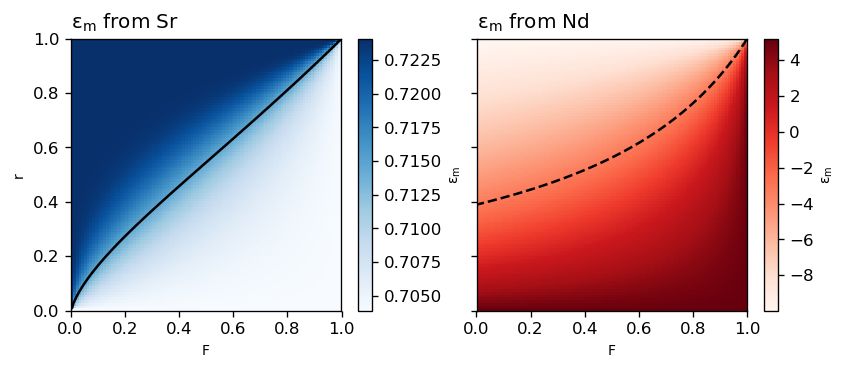

In [356]:
# plot epsilon as a function of r and F, with the measured epsilon value contours.
fig, (srax, ndax) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

csr = srax.pcolormesh(gF, gr, eps_Sr, cmap=plt.cm.Blues)
srax.contour(gF, gr, eps_Sr, [obs_Sr], colors='k')
fig.colorbar(csr, ax=srax, label='$\epsilon_m$')

srax.set_ylabel('r')
srax.set_xlabel('F')
srax.set_title('$\epsilon_m$ from Sr', loc='left')

cnd = ndax.pcolormesh(gF, gr, eps_Nd, cmap=plt.cm.Reds)
ndax.contour(gF, gr, eps_Nd, [obs_Nd], colors='k')
fig.colorbar(cnd, ax=ndax, label='$\epsilon_m$')

ndax.set_xlabel('F')
ndax.set_title('$\epsilon_m$ from Nd', loc='left')

The contours here show the *observed* isotopic composition of the samples.

In a single isotope system, the observed value can be explained by a range of possible $r$ and $F$ pairs, along the contour lines.

Considering two isotope systems constrains the possible solution to a single pair of $r$ and $F$ values (the intersection of the contours):

Text(0,0.5,'r')

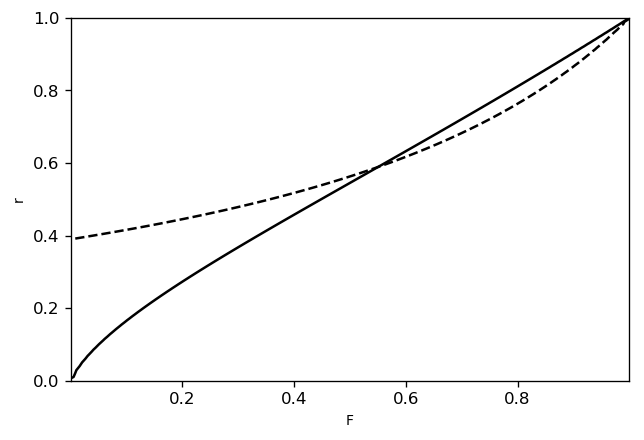

In [357]:
fig, ax = plt.subplots(1, 1)

ax.contour(gF, gr, eps_Sr, [0.71458], colors='k')
ax.contour(gF, gr, eps_Nd, [-3.19], colors='k')

ax.set_xlabel('F')
ax.set_ylabel('r')

Visually, it's really easy to see where the intercept is, but how do we do this programatically?

### 1. Numerically
Calculate $\epsilon_m$ for the entire parameter space, work out the contours, and then find their intercept.

Pros:
- Simple (don't have to think much).
- Applicable to very complex systems that evade algebraic solutions.

Cons:
- Computationally expensive - have to calculate the entire parameter space every time. Quickly becomes unmanageable in multi-dimensional cases.

Let's do it!

In [358]:
# a few packages to help working out the intersections of contours
import matplotlib._cntr as cntr
from shapely import geometry
from scipy import stats
from tqdm import tqdm

In [359]:
def get_contour_verts(x, y, z, c):
    """
    Calculate vertices ([x, y] coordinates) of contour across a matrix.
    """
    contour = cntr.Cntr(x, y, z)
    return contour.trace(c)[0]

def get_intersect(v1, v2):
    """
    Calculate the intersection of two sets of vertices.
    """
    p1 = geometry.LineString(v1)
    p2 = geometry.LineString(v2)
    intersect = p1.intersection(p2)
    return intersect.x, intersect.y

def calc_rF(gr, gF, Sr_params, Nd_params, obs_Sr, obs_Nd):
    """
    Calculate the intersect of the Sr and Nd contours.
    """
    # calculate eps based on Sr and Nd
    eps_Sr = eps_calc(r=gr, F=gF, **Sr_params)
    eps_Nd = eps_calc(r=gr, F=gF, **Nd_params)

    # get vertices of contour
    v_Sr = get_contour_verts(gF, gr, eps_Sr, obs_Sr)
    v_Nd = get_contour_verts(gF, gr, eps_Nd, obs_Nd)

    return get_intersect(v_Sr, v_Nd), (v_Sr, v_Nd)

In [360]:
# F and r space to consider
F = np.linspace(0.001, 0.999, 100)
r = np.linspace(0, 0.999, 100)
gF, gr = np.meshgrid(F, r)

eps_Sr = 0.71458
eps_Nd = -3.19

(F, r), verts = calc_rF(gr, gF, Sr_params, Nd_params, obs_Sr, obs_Nd)

Text(0,0.5,'r')

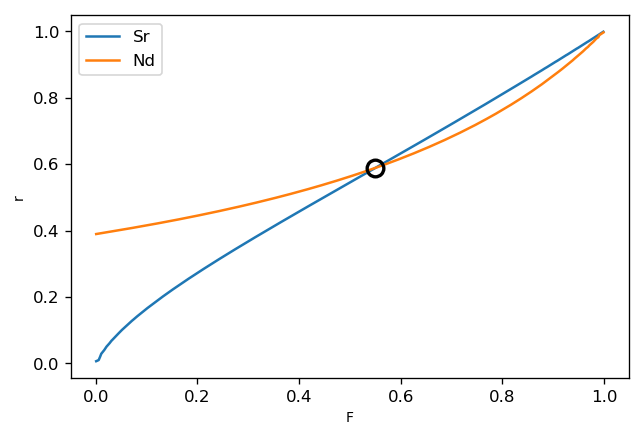

In [361]:
plt.plot(verts[0][:,0], verts[0][:,1], label='Sr')
plt.plot(verts[1][:,0], verts[1][:,1], label='Nd')
plt.scatter(F, r, zorder=3, marker='o', s=100, facecolor=(0,0,0,0), edgecolor=(0,0,0,1), lw=2)

plt.legend()

plt.xlabel('F')
plt.ylabel('r')

It works! But this isn't very elegant, and will be relatively slow later one... So:

### 2. Optimisation

Use an optimisation algorithm to calculate the intersection of the two contours.

Pros:
- Simple
- Computationally Fast

Cons:
- System has to be algebraically manageable, i.e.
- Can't apply to very complex sytems.

To do this, we first need to re-arrange our equation to solve for one of the unknowns ($r$ or $F$). $F$ is simpler, so:

$$
F = \left[\frac{\frac{r}{r - 1}\frac{C_a}{z} (\epsilon_a - \epsilon_m) + C_m^0 (\epsilon_m - \epsilon_m^0)}{\frac{r}{r - 1}\frac{C_a}{z} (\epsilon_a - \epsilon_m)}\right]^{\frac{1}{z}}
$$

In [362]:
def F_calc(eps_m, Ca, D, r, eps_a, Cm0, eps_m0):
    """
    Calculate F as a function of r and known inputs.
    """
    
    z = (r + D - 1) / (r - 1)
    z[z==0] = np.nan
    
    R = (r / (r - 1)) * (Ca / z)
    
    top = (R * (eps_a - eps_m) + Cm0 * (eps_m - eps_m0))
    bot = (R * (eps_a - eps_m))
    
    frac = top / bot
    frac[frac < 0] = np.nan
        
    return (frac)**(1/z)

In [363]:
r = np.linspace(0.01, 0.98, 100)
F_Sr = F_calc(eps_Sr, r=r, **Sr_params)
F_Nd = F_calc(eps_Nd, r=r, **Nd_params)

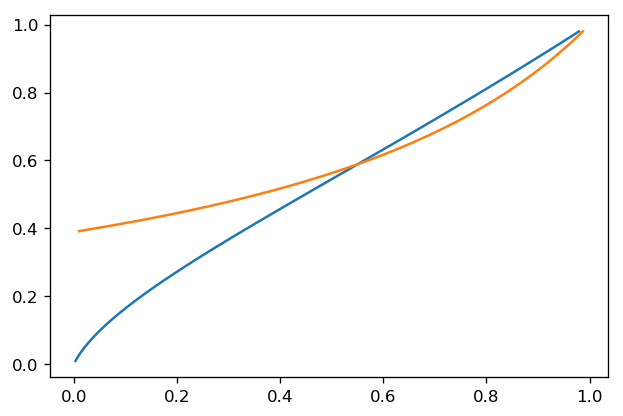

In [364]:
plt.plot(F_Sr, r)
plt.plot(F_Nd, r)

The point where the contours cross is the solution, or when one minus the other is zero:

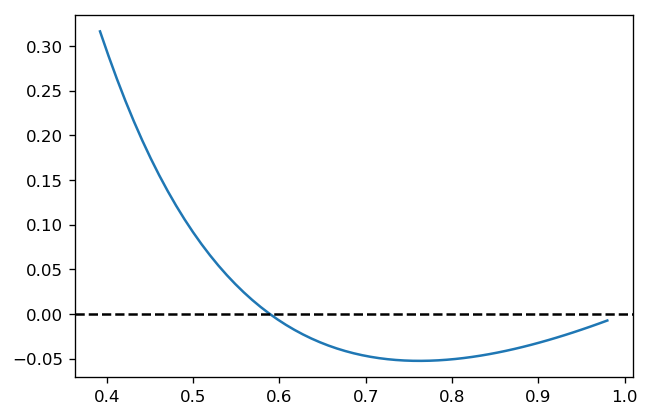

In [365]:
plt.plot(r, F_Sr - F_Nd)
plt.axhline(0, ls='dashed', c='k')

Now we can use a zero finder to work out the R value where both F values are equal:

In [366]:
import scipy.optimize as opt

In [367]:
# Write a function to return the difference between the two contours
def calc_r(r, Sr_params, Nd_params, eps_Sr, eps_Nd):
    F_Sr = F_calc(eps_Sr, r=r, **Sr_params)
    F_Nd = F_calc(eps_Nd, r=r, **Nd_params)
    return (F_Sr - F_Nd)**2

In [368]:
# optimise for R
opt_r = opt.minimize(calc_r, 0.5, (Sr_params, Nd_params, eps_Sr, eps_Nd), bounds=[(0.001, 0.999)]).x

# calculate corresponding F value
opt_F = F_calc(eps_Sr, r=opt_r, **Sr_params)

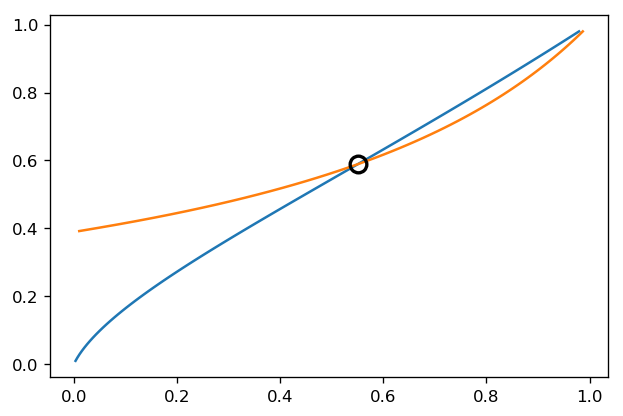

In [369]:
plt.plot(F_Sr, r)
plt.plot(F_Nd, r)
plt.scatter(opt_F, opt_r, zorder=3, marker='o', s=100, facecolor=(0,0,0,0), edgecolor=(0,0,0,1), lw=2)

It works!

### 3. Algebraically

Because we have two constraints on the system, we can treat them like simultaneous equations.

i.e. we could substitute the definition of $F$ for the Sr case into the overall equation for the Nd case, and then solve for $r$.

Pros:
- Elegant
- Very computationally fast

Cons:
- Algebra.

Don't have time to do this now. We'll go with the optimisation option.

## Problem:
All the methods above give us a *single* solution for $r$ and $F$. We know this isn't correct, because the model inputs have uncertainties associated with them.

How do we work out how these uncertainties influence our result?

### Algebraically?

If your problem is suitable for an algebraic solution, could could propagate the uncertainties?

But in practice, this is often prohibitively complex...

### Monte-Carlo?

This is a 'brute force' approach to computationally accounting for uncertainties. You do the calculation lots ($10^{lots}$) of times, varying each input parameter randomly within its uncertainty limits, and look at the *distribution* of the results. This gives you a nice way of getting a realistic estimate of uncertainties associated with your inputs.

**Important Caveat:** Monte-Carlo is 'dumb' - the outputs are only valid if your *model* is valid.

### Implementation

In Monte-Carlo, your parameters are no longer single values, they are described by *probability functions*, which describe your parameter as a range of possibilities, rather than a single values.

For reference, the most 'basic' function is a Gaussian or 'normal' distribution, which underpins most parametric statistics. As a demo, the `scipy.stats` package has a really nice way of handling these probability functions:

In [370]:
norm = stats.norm(0, 0.2)  # make a normal distribution centered on zero with a standard deviation of 0.2

norm

This creates a 'continuous distribution object', rather than numbers. It has defining properties (mean, standard deviation), and is able to generate data based on those properties.

For example, you can make a probability density function, which is the Gaussian distribution you're all familiar with:

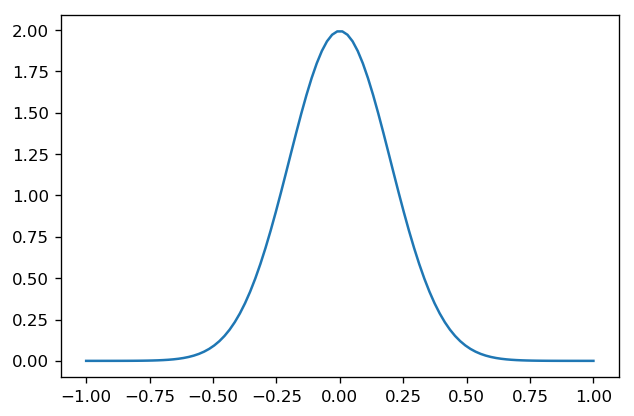

In [371]:
x = np.linspace(-1, 1, 100)  # make a dependent variable
y = norm.pdf(x)  # generate the probability density function for the normal distribution

plt.plot(x, y)

We're going this slightly convoluted route because, once defined, these 'continuous distribution objects' have a number of useful properties that can be used in monte carlo iterations. In particular, the `.rvs(N)` method produces `N` random variables from within the specified distribution:

In [372]:
norm.rvs(10)

array([-0.18226251, -0.02586016, -0.18906464,  0.09056409, -0.16605748,
       -0.1859579 ,  0.24369128, -0.18509248,  0.02519028, -0.10002106])

This produces 10 random numbers centered around zero, with a standard deviation of 0.2. If you run this cell repeatedly, you'll get a different set of random numbers each time.

Also, the 'continuous distribution object' infrastructure has [LOADS of different types of distributions built in](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions), so allows you to pick any arbitrary error function for your inputs.

Using this approach, we can define our paramters as *probability distributions*, rather than single values.

In [373]:
# define uncertainties for monte carlo
Sr_params_oceanic = {'Ca': stats.norm(191, 50),
                     'D': stats.norm(2, 0.1),
                     'eps_a': stats.norm(0.72407, 0.002),
                     'Cm0': stats.norm(150, 75),
                     'eps_m0': stats.norm(0.7055, 0.001)}

Nd_params_oceanic = {'Ca': stats.norm(57, 16),
                     'D': stats.norm(0.01, 0.0005),
                     'eps_a': stats.norm(-10, 0.37),
                     'Cm0': stats.norm(5, 2.61),
                     'eps_m0': stats.norm(3.2, 1.45)}

# define uncertainties for monte carlo
Sr_params_mantle = {'Ca': stats.norm(191, 50),
                    'D': stats.norm(2, 0.1),
                    'eps_a': stats.norm(0.72407, 0.002),
                    'Cm0': stats.norm(570, 84),
                    'eps_m0': stats.norm(0.7039, 0.002)}

Nd_params_mantle = {'Ca': stats.norm(57, 16),
                    'D': stats.norm(0.01, 0.0005),
                    'eps_a': stats.norm(-10, 0.37),
                    'Cm0': stats.norm(30, 4.5),
                    'eps_m0': stats.norm(5.2, 1.6)}

# Note: No D uncertainties provided, so I added an arbitrary 5% uncertainty

We've defined two sets of parameters, for two different end-member compositions in the model (Oceanic and Mantle). Note how each parameter is now defined as a distribution 'object', rather than a single value. 

All of these are defined as normal distributions, but these can be easily swapped out for [any of the other distributions available in `scipy.stats`](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions).

Now we can use these parameter definitions to generate a unique, random set of parameters in each monte-carlo iteration.

However, a syntactic aside: because we've stored our parameters in dictionaries, not individual values, it's a bit tricky to get the random value (`.rvs()`) of all the variables. To so this, we'll use a bit of Python syntax trickery, known as 'dictionary comprehension' - a slightly more advanced take on 'list comprehension'. [Here's a handy guide](https://www.datacamp.com/community/tutorials/python-dictionary-comprehension). Briefly, the following loops through every item of the dictionary, and gets its random (`.rvs()`) value:

In [374]:
{k: v.rvs() for k, v in Sr_params_oceanic.items()}

{'Ca': 192.83666199676074,
 'Cm0': 252.4817726764705,
 'D': 2.039076909264347,
 'eps_a': 0.7227472186265932,
 'eps_m0': 0.7065514869231683}

This is what we'll use in each monte carlo loop.

To simplify the application of Monte Carlo, I've put it all inside a function, which can be applied to different input parameter sets:

In [375]:
def MC_rF(gr, gF, Sr_param_dists, Nd_param_dists, obs_Sr, obs_Nd, N=1e3):
    # create some empty objects to hold the output data.
    out = np.full((2, int(N)), np.nan)
    params = []
    # do the iterations
    for i in tqdm(range(int(N)), total=int(N)):
        success = False
        while not success:
            # calculate random parameters for the iteration
            Sr_params = {k: v.rvs() for k, v in Sr_param_dists.items()}
            Nd_params = {k: v.rvs() for k, v in Nd_param_dists.items()}
            # calculate starting guess
            # Note: equation naturally converges towards F=1 and r=1, so we bias the initial
            # guess towards a lower value, to prevend spurious convergence towards this end point.
            rs = np.linspace(0.01, 0.5, 100)  # r range to use for initial guess
            init = (F_calc(obs_Sr, r=rs, **Sr_params) - F_calc(obs_Nd, r=rs, **Nd_params))**2
            r0 = rs[init == np.nanmin(init)]  # initial guess is r value where F difference is closest to zero.

            try:
                # use a zero finder to find the root (zero point)
                opt_r = opt.fsolve(calc_r, r0, 
                                   (Sr_params, Nd_params,
                                    obs_Sr, obs_Nd))
                opt_F = F_calc(obs_Sr, r=opt_r, **Sr_params)
                if (opt_r < 0.99) & (opt_F < 0.99):
                    # exclude values where both r and F => 1
                    # this is an artefact o
                    success = True
            except:
                pass
        # save the optimal paramters
        out[:, i] = opt_F, opt_r
        # save the input paramters for each iteration
        params.append([Sr_params, Nd_params])
            
    return out, params

#### Python Note:
There's some more complex 'control flow' going on here - note the `while` and `try`/`except` parts of the function.
I'm using this to implement some 'quality control' criteria, based on what we know about the function. In basic terms, the flow of the iteration is:

1. Record that the iteration has started, and has not been sucessful yet (`success = False`).
2. Check that the iteration hasn't been completed yet (`while not success`)
3. Start iteration, generate random parameters, calculate initial r guess.
4. Using random parameters and initial r guess, try to find the r solution. If it fails for any reason, return to (2), otherwise go to (5).
5. Quality control. Check whether both the $r$ and $F$ values are less than 0.99. If not return to (2), if yes go to (6).
6. Record that the fit has been succesful (`success = True`, breaks the `while` loop), and record the outputs. Return to (1) for start of next iteration.

This allows the function to run the specified number of iterations, while not freaking out at cases where there is no solution (no intersection of the results), or it produces physically non-sensical results (F and r => 1).

## Let's look at the results!

In [376]:
def plot_MC(F_bs, r_bs, params, eps_Sr, eps_Nd, lines=True):
    # a function for plotting the results
    
    fig = plt.figure(figsize=[6, 6])

    # create axes
    hax = fig.add_axes([.1, .1, .6, .6])
    rax = fig.add_axes([.7, .1, .2, .6])
    Fax = fig.add_axes([.1, .7, .6, .2])

    # define axis limits
    Flim = (0, 1)
    rlim = (0, 1)
    
    # plot intersections
    hax.scatter(F_bs, r_bs, alpha=0.05, s=10, c='k', zorder=2)
        
    # labels and limits
    hax.set_xlim(Flim)
    hax.set_ylim(rlim)
    hax.set_xlabel('F')
    hax.set_ylabel('r')
    
    # plot lines
    if lines:
        r = np.linspace(0.01, 0.99, 100)
        for sr_par, nd_par in tqdm(params, desc='Drawing Lines'):
            hax.plot(F_calc(eps_Sr, r=r, **sr_par), r, c='b', alpha=0.005, lw=2, zorder=-5)
            hax.plot(F_calc(eps_Nd, r=r, **nd_par), r, c='r', alpha=0.005, lw=2, zorder=-4)

        # make legend
        hax.plot([], [], c='r', label='Nd')
        hax.plot([], [], c='b', label='Sr')
        hax.legend()
    
    # draw R histogram
    rax.hist(r_bs, 30, orientation='horizontal')
    rax.set_ylim(rlim)
    rax.set_yticklabels([])
    rax.set_xticks(rax.get_xticks()[1:])
    rax.xaxis.tick_top()
    
    fig.text(.8,.8,'N')
    
    rstats = np.percentile(r_bs, [50, 2.5, 97.5])
    for ax in [rax]:#, hax]:
        ax.axhline(rstats[0], c='r')
        ax.axhspan(*rstats[1:], color='r', alpha=0.08)
    rax.text(.98, .99, '{:.2f}\n({:.2f}/+{:.2f})'.format(rstats[0], *(rstats[1:] - rstats[0])),
             transform=rax.transAxes, va='top', ha='right')

    # draw F histogram
    Fax.hist(F_bs, 30)
    Fax.set_xlim(Flim)
    Fax.set_xticklabels([])
    Fax.set_yticks(Fax.get_yticks()[1:])
    Fax.yaxis.tick_right()
    
    Fstats = np.percentile(F_bs, [50, 2.5, 97.5])
    for ax in [Fax]:#, hax]:
        ax.axvline(Fstats[0], c='r')
        ax.axvspan(*Fstats[1:], color='r', alpha=0.08)
    Fax.text(.98, .99, '{:.2f}\n({:.2f}/+{:.2f})'.format(Fstats[0], *(Fstats[1:] - Fstats[0])),
             transform=Fax.transAxes, va='top', ha='right')
    
    return fig, (hax, Fax, rax)

### ARD, Oceanic End Member

In [377]:
(F_bs, r_bs), par = MC_rF(gr, gF, Sr_params_oceanic, Nd_params_oceanic, 0.71458, -3.19, 5e3)

  0%|          | 22/5000 [00:00<00:24, 205.65it/s]/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
  5%|▌         | 252/5000 [00:00<00:17, 274.65it/s]/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
100%|██████████| 5000/5000 [00:20<00:00, 245.98it/s]


Drawing Lines: 100%|██████████| 5000/5000 [01:23<00:00, 60.08it/s] 


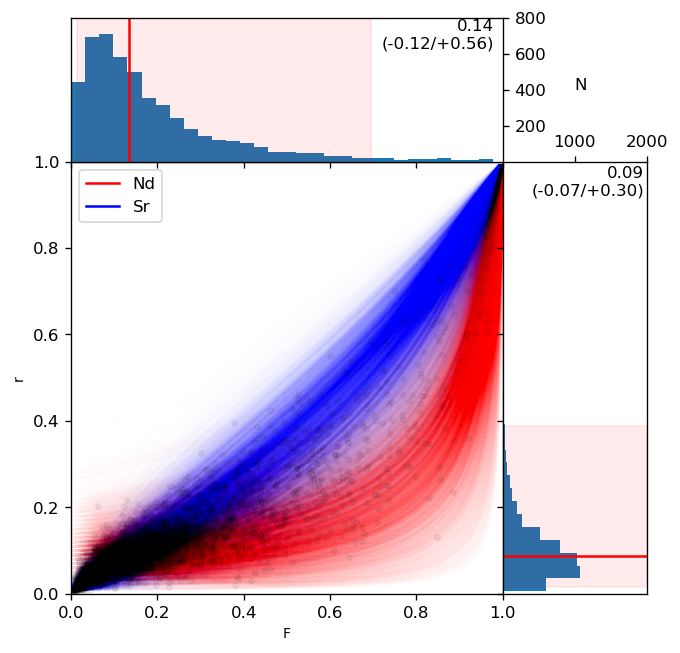

In [378]:
fig, (hax, Fax, rax) = plot_MC(F_bs, r_bs, par, eps_Sr, eps_Nd)

Note that the range of possibile $r$ and $F$ values are not independent - there is correlation in the outputs. It might therefore be more appropriate to represent the uncertainties as a 'field', rather than simple confidence intervals, which does not incorporate this correlation. This is particularly obvious if you look at a 2D histogram of the data:

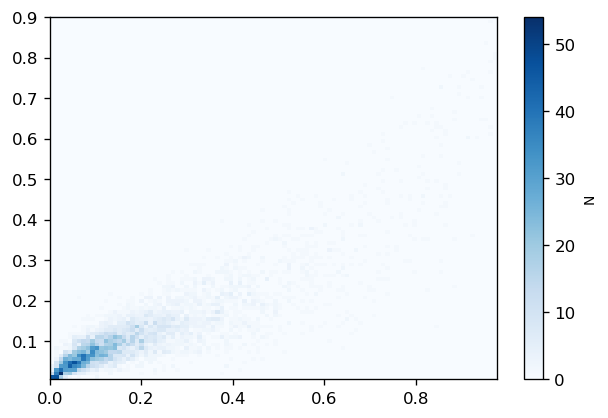

In [379]:
_ = plt.hist2d(F_bs, r_bs, 100, cmap=plt.cm.Blues)
plt.colorbar(label='N')

### ARD, Mantle End Member

In [380]:
(F_bs, r_bs), par = MC_rF(gr, gF, Sr_params_mantle, Nd_params_mantle, 0.71458, -3.19, 5e3)

  2%|▏         | 85/5000 [00:00<00:24, 204.28it/s]/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
 40%|███▉      | 1993/5000 [00:07<00:11, 256.94it/s]/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
100%|██████████| 5000/5000 [00:19<00:00, 250.98it/s]


Drawing Lines: 100%|██████████| 5000/5000 [01:15<00:00, 66.13it/s] 


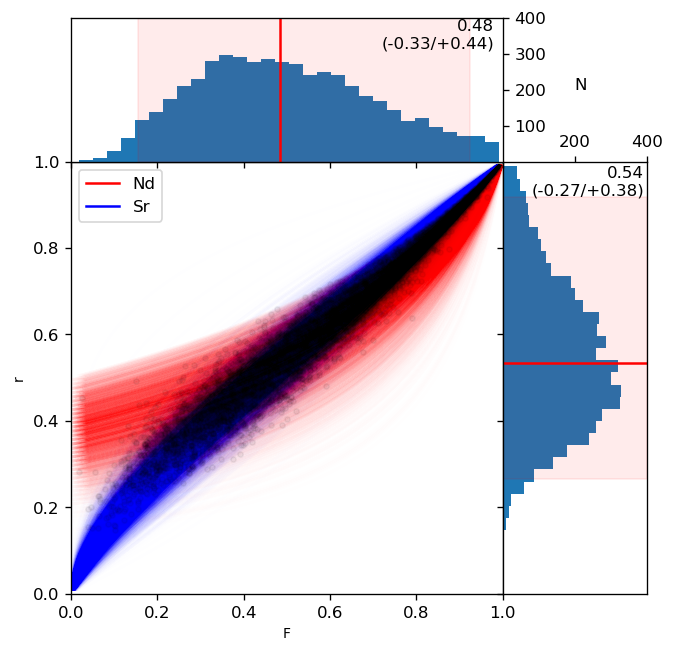

In [381]:
fig, (hax, Fax, rax) = plot_MC(F_bs, r_bs, par, eps_Sr, eps_Nd)

### GQFP, Oceanic End-Member

In [382]:
(F_bs, r_bs), par = MC_rF(gr, gF, Sr_params_oceanic, Nd_params_oceanic, 0.71149, -3.9, 5e3)

  0%|          | 23/5000 [00:00<00:21, 228.31it/s]/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
 23%|██▎       | 1160/5000 [00:04<00:16, 232.06it/s]/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
100%|██████████| 5000/5000 [00:22<00:00, 219.39it/s]


Drawing Lines: 100%|██████████| 5000/5000 [01:22<00:00, 60.58it/s] 


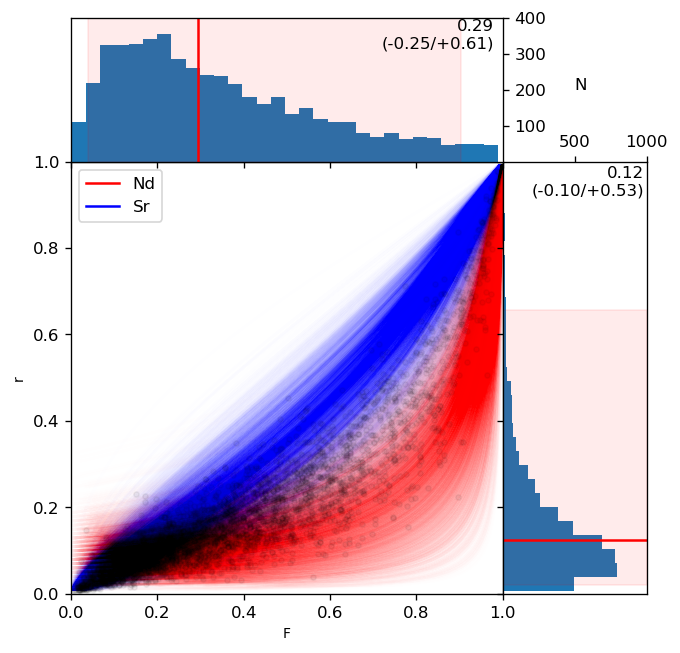

In [383]:
fig, (hax, Fax, rax) = plot_MC(F_bs, r_bs, par, eps_Sr, eps_Nd)

### GQFP, Mantle End-Member

In [384]:
(F_bs, r_bs), par = MC_rF(gr, gF, Sr_params_mantle, Nd_params_mantle, 0.71149, -3.9, 5e3)

  0%|          | 10/5000 [00:00<00:53, 93.95it/s]/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
  3%|▎         | 172/5000 [00:01<00:33, 143.55it/s]/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':
100%|██████████| 5000/5000 [00:38<00:00, 128.45it/s]


Drawing Lines: 100%|██████████| 5000/5000 [01:20<00:00, 62.04it/s] 


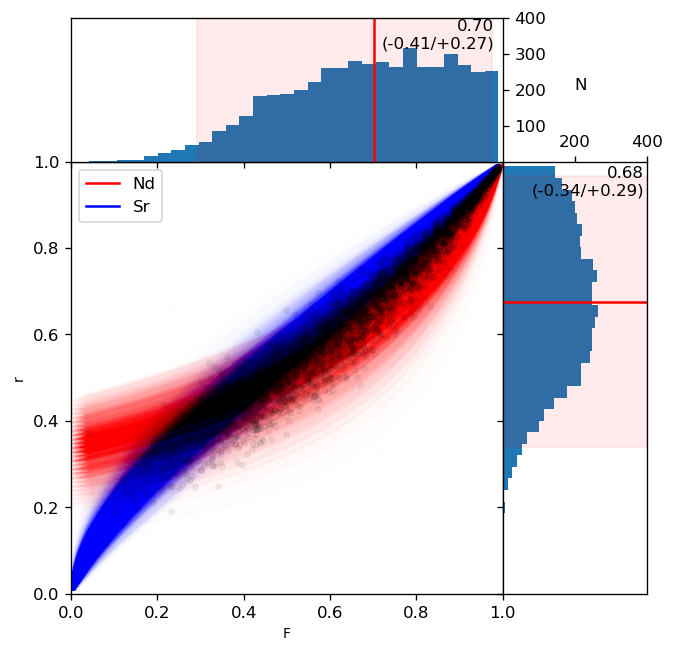

In [385]:
fig, (hax, Fax, rax) = plot_MC(F_bs, r_bs, par, eps_Sr, eps_Nd)

## One Step Further: Sensitivity Analysis?

We now have a grasp of how the combined uncertainties in each of the inputs influences the output. We can go one step furter than this, and think about how *important* the uncertainties in each of the parameters is to the output.

You could do this algebraically (partial derivatives), or take a similar monte-carlo type approach, to estimate the sensitivity of the output to uncertainty in each parameter. This could guide future experiments to better constrain the uncertainties on the inputs.

To do this, we'll calcualte the model varying each parameter individually, to see their relative importance. 

In [386]:
# this varies each parameter individually across its standard deviation (keeping all others constant).

obs_Sr = 0.71458
obs_Nd = -3.19

rs = np.linspace(0.01, 0.5, 100)  # r range to use for initial guess
Sr_params = {p: v.args[0] for p, v in Sr_params_oceanic.items()}
Nd_params = {p: v.args[0] for p, v in Nd_params_oceanic.items()}
sa = {}

vpar = ['Ca', 'D', 'eps_a', 'Cm0', 'eps_m0']

for k in vpar:
    
    # Sr parameter sensitivity
    sr_v = Sr_params_oceanic[k]
    sr_var = np.linspace(sr_v.mean() - sr_v.std(),
                         sr_v.mean() + sr_v.std(), 100)
    sa['sr_' + k] = {'x': sr_var, 'dx': sr_var - sr_v.mean()}

    sr_params = {p: v.args[0] for p, v in Sr_params_oceanic.items() if p != k}
    
    F = []
    r = []
    for pi in sr_var:
        sr_params[k] = pi
        
        init = (F_calc(obs_Sr, r=rs, **sr_params) - F_calc(obs_Nd, r=rs, **Nd_params))**2
        r0 = rs[init == np.nanmin(init)]  # initial guess is r value where F difference is closest to zero.
        
        ri = opt.fsolve(calc_r, r0, (sr_params, Nd_params, obs_Sr, obs_Nd))
        r.append(ri)
        F.append(F_calc(obs_Sr, r=ri, **sr_params))
    sa['sr_' + k]['r'] = np.concatenate(r)
    sa['sr_' + k]['F'] = np.concatenate(F)
    
    # Nd parameter sensitivity
    nd_v = Nd_params_oceanic[k]
    nd_var = np.linspace(nd_v.mean() - nd_v.std(),
                         nd_v.mean() + nd_v.std(), 100)
    sa['nd_' + k] = {'x': nd_var, 'dx': nd_var - nd_v.mean()}
    
    nd_params = {p: v.args[0] for p, v in Nd_params_oceanic.items() if p != k}
    
    F = []
    r = []
    for pi in nd_var:
        nd_params[k] = pi
        
        init = (F_calc(obs_Sr, r=rs, **Sr_params) - F_calc(obs_Nd, r=rs, **nd_params))**2
        r0 = rs[init == np.nanmin(init)]  # initial guess is r value where F difference is closest to zero.
        
        ri = opt.fsolve(calc_r, r0, (Sr_params, nd_params, obs_Sr, obs_Nd))
        r.append(ri)
        F.append(F_calc(obs_Nd, r=ri, **nd_params))
    sa['nd_' + k]['r'] = np.concatenate(r)
    sa['nd_' + k]['F'] = np.concatenate(F)

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


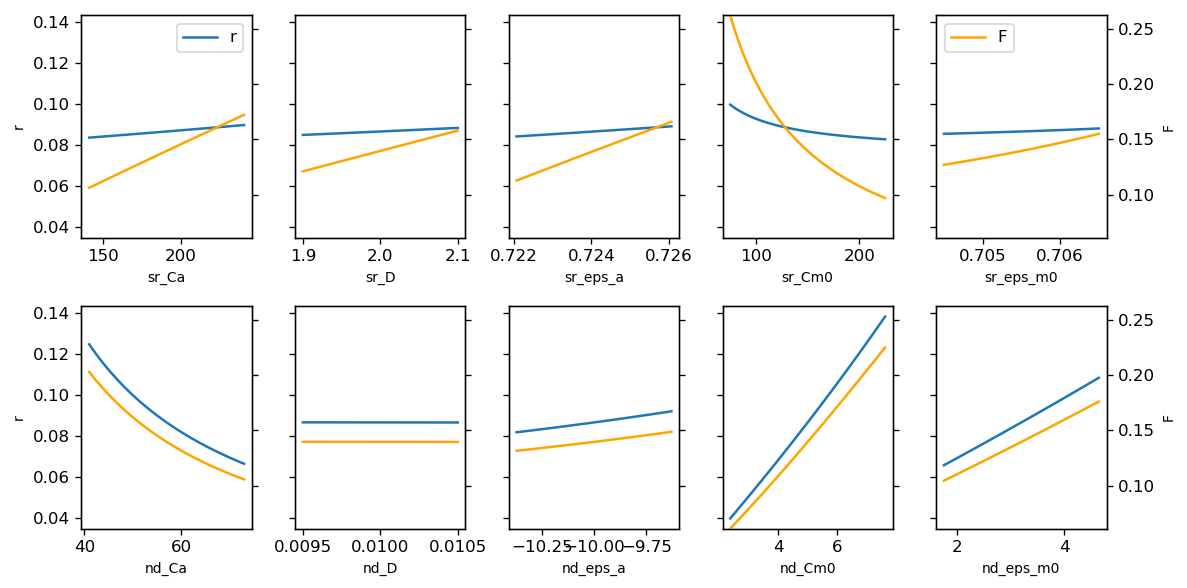

In [388]:
fig, axs = plt.subplots(2, 5, figsize=[10, 5], sharey=True)

ax2s = []
Flims = []

for k, ax in zip(vpar, axs[0]):
    ik = 'sr_' + k
    ax.plot(sa[ik]['x'], sa[ik]['r'], label='r')
    ax.set_xlabel(ik)
    
    ax2 = ax.twinx()
    ax2.plot(sa[ik]['x'], sa[ik]['F'], c='orange', label='F')
    ax2s.append(ax2)
    Flims.append(np.min(sa[ik]['F']))
    Flims.append(np.max(sa[ik]['F']))
    
for k, ax in zip(vpar, axs[1]):
    ik = 'nd_' + k
    ax.plot(sa[ik]['x'], sa[ik]['r'])
    ax.set_xlabel(ik)
    
    ax2 = ax.twinx()
    ax2.plot(sa[ik]['x'], sa[ik]['F'], c='orange')
    ax2s.append(ax2)
    Flims.append(np.min(sa[ik]['F']))
    Flims.append(np.max(sa[ik]['F']))
    
for ax in axs[:, 0]:
    ax.set_ylabel('r')

for ax in ax2s:
    ax.set_ylim(np.min(Flims), np.max(Flims))
    if not ax.is_last_col():
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('F')

axs[0, 0].legend()        
ax2s[4].legend(loc='upper left')

fig.tight_layout()

From this we can see that some parameter uncertainties have a much greater effect on the results than others (in particular, Cm0 could be a good place to focus uncertainty-reduction efforts). Note that this is an sensitivity analysis for one particular case (Oceanic end-member) - you might see different patterns for the mantle end-member case.